Imports and Logging Configuration

In [1]:
import requests
import json
import subprocess
import pandas as pd
import datetime
import logging
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from io import BytesIO

# Configure logging
logging.basicConfig(level=logging.DEBUG,  # Set the logging level to DEBUG
                    format='%(asctime)s - %(levelname)s - %(message)s',  
                    filename='flight destinations forecast.log',  
                    filemode='w') 


City Latitude and Longitude Retrieval

In [2]:
def city_lon_lat(row):
    city_name=row['City name']
    country_code=row['Country Abbrev.']
    global openweathermap_api_key
    url = f'http://api.openweathermap.org/geo/1.0/direct?q={city_name},{country_code}&limit=5&appid={openweathermap_api_key}'
    response = requests.get(url,verify=False)
    if response.status_code == 200:
        forecast_data_of_city = response.json()  # Convert response to JSON format
        #print(forecast_data_of_city)
    else:
        raise Exception('Error with openweathermap:', response.status_code, response.reason)

    lat=forecast_data_of_city[0]['lat']
    lon=forecast_data_of_city[0]['lon']
    return({'lat':lat,'lon':lon})


In [4]:
   
def convert_to_gmt_plus_2(timestamp):#there is bug here!
        utc_datetime = datetime.datetime.utcfromtimestamp(timestamp)
        gmt_plus_2_datetime = utc_datetime + datetime.timedelta(hours=2)
        return gmt_plus_2_datetime


Weather Forecast Retrieval

In [5]:
def weather_forecast_for_city(openweathermap_api_key,city_name,lat,lon):
    __doc__=\
    '''
    bring the weather forecast for the next 5 days with hourly granularity
    '''
    # api to get forecast weather for the next 5 days, every 3 hours:
    url = f'https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&units=metric&appid={openweathermap_api_key}'
    response = requests.get(url,verify=False)
    if response.status_code == 200:
        weather_data = response.json()  # Convert response to JSON formatd
    else:
        raise Exception('Error with api.openweathermap:', response.status_code,response)
    df_with_weather_col_as_list=pd.json_normalize(weather_data['list'])
    df_with_weather_col_as_list['city_name']=city_name
    # since weather column is list of dict (which json_normalize couldnt handle) I had to concat it to the full table, with a prefix or 'weather.' for each column.
    df_with_weather_col_normalized=pd.concat([df_with_weather_col_as_list.drop(['weather'],axis=1),pd.json_normalize(weather_data['list'],'weather',record_prefix='weather.')],axis=1)
    df_weather_prepared= df_with_weather_col_normalized #df_with_weather_col_normalized[interesting_columns]
    df_weather_prepared.loc[:,'Forecast Time (Israel Time)']=df_weather_prepared['dt'].apply(convert_to_gmt_plus_2)
    df_weather_prepared.loc[:,'dt']=pd.to_datetime(df_weather_prepared['dt'], unit='s') 
    df_weather_prepared['main.temp_min']=df_weather_prepared['main.temp_min'].astype(int)
    df_weather_prepared['main.temp_max']=df_weather_prepared['main.temp_max'].astype(int)
    return df_weather_prepared

Air Pollution Forecast Retrieval

In [7]:
def get_air_pollution_city(openweathermap_api_key,city_name,lat,lon):
    __doc__=\
    '''
    bring the air pollution forecast for the next 4 days with hourly granularity
    '''
    def aqi_desc(aqi):
        match aqi:
            case 1:return 'Good'
            case 2:return 'Fair'
            case 3:return 'Moderate'
            case 4:return 'Poor'
            case 5:return 'Very Poor'
            case _:return 'N/A'  # Default case for values not covered in the predefined cases
    
    ## API for Air Pollution:
    air_pollution_url=f'http://api.openweathermap.org/data/2.5/air_pollution/forecast?lat={lat}&lon={lon}&appid={openweathermap_api_key}'
    response=requests.get(air_pollution_url)
    if response.status_code==200:
        air_pol_dict_type=response.json()
    else:
        raise Exception(response.status_code)
    df_air_pollution=pd.json_normalize(air_pol_dict_type['list'])
    df_air_pollution_subset=df_air_pollution[['dt','main.aqi']].copy()
    df_air_pollution_subset['aqi desc']=df_air_pollution_subset['main.aqi'].apply(aqi_desc)
    df_air_pollution_subset['dt GMT']=df_air_pollution_subset['dt'].apply(convert_to_gmt_plus_2) 
    df_air_pollution_subset['dt']=pd.to_datetime(df_air_pollution_subset['dt'], unit='s') 
    df_air_pollution_subset['city_name']=city_name
    return(df_air_pollution_subset)


Amadeus API Token Retrieval

In [8]:
def get_token_from_amadeus():
    client_id = 'xNoWUqmFVVeDmNjPAQAal3w9CBngCr0N'
    client_secret = 'c8U8GSe7CANowHZQ'

    # Define the command and its arguments as a list
    command = [
        'curl',
        '--insecure',
        'https://test.api.amadeus.com/v1/security/oauth2/token',
        '-H',
        'Content-Type: application/x-www-form-urlencoded',
        '-d',
        f'grant_type=client_credentials&client_id={client_id}&client_secret={client_secret}'
    ]
    # Run the command
    try:
        output = subprocess.run(command, capture_output=True, text=True)
    except:
        logging.exception('Error occured in api.amadeus')
        raise Exception('Error occured in api.amadeus: ',Exception)         
    else: 
        #
        amadeus_access_token=json.loads(output.stdout)['access_token']
        print('Token recieved successfully from Amadeus')
        print('please wait while creating weather forecast for all avaliable flight destinations...')
        return(amadeus_access_token)



Flight Destination Retrieval

In [9]:
def get_possible_flight_destinations(amadeus_access_token,origin,departureDate,oneWay,duration,nonStop,maxPrice,viewBy):
    __doc__=\
    '''
    Fetches possible flight destinations from Amadeus API based on provided parameters.
    Parameters:
    - amadeus_access_token (str): Access token for Amadeus API authentication.
    - origin (str): Three-letter IATA code for the origin airport.
    - departureDate (str): Date of departure in YYYY-MM-DD format.
    - oneWay (bool): Indicates if the search is for one-way flights.
    - duration (int): Min and Maximum duration of the trip in days.
    - nonStop (bool): Indicates if only non-stop flights are preferred.
    - maxPrice (float): Maximum price limit for the flights.
    - viewBy (str): Method to view the flight results (e.g., 'COUNTRY', 'AIRPORT', 'CITY').
    Returns:
    - flight_destinations (pandas.DataFrame): DataFrame containing information about possible flight destinations.
    Note:
    - This function utilizes the Amadeus API to retrieve flight destination data based on the provided parameters.
    - It returns the flight destinations in a pandas DataFrame format.
    '''
    command=[
    'curl',
    '--insecure',
    f'https://test.api.amadeus.com/v1/shopping/flight-destinations?origin={origin}&departureDate={departureDate}&oneWay={oneWay}&duration={duration}&nonStop={nonStop}&maxPrice={maxPrice}&viewBy={viewBy}',
    '-H',
    f'Authorization: Bearer {amadeus_access_token}'
    ]
    # Run the command
    try:
        output = subprocess.run(command, capture_output=True, text=True)
    except Exception:
        logging.exception('Error Occured with getting possible flights from Amadeus')
        raise Exception('Error Occured with getting possible flights from Amadeus:',Exception)
    else:
        try:
            flight_destinations=pd.json_normalize(json.loads(output.stdout)['data'])
        except KeyError:
             print('Error occured when trying to get flight destinations: ',json.loads(output.stdout)['errors'][0]['detail'])
             logging.exception('Error occured when trying to get flight destinations')
             raise Exception(KeyError)
        except Exception:
             print ('the error: ' ,Exception)
             logging.exception('Error occured when trying to get flight destinations')
             exit(1)
        else: 
            try:
                with open('flight_destinations.csv','w') as f:
                        flight_destinations.to_csv(f,lineterminator='\n',index=False,header=True,sep=',')
            except FileExistsError:
                logging.exception(e)
                raise Exception('file flight_destinations.csv already exists:' ,FileExistsError)
            except PermissionError:
                logging.exception('File is flight_destinations.csv is open. please close it')
                raise Exception('File is flight_destinations.csv is open. please close it')
            except Exception as e:
                    logging.exception(e)
                    raise Exception(Exception)
            return(flight_destinations)

In [10]:
def get_cities_names_with_flight_destinations(flight_destinations):
    __doc__=\
    '''
    The script matches flight destinations with their respective cities using airport codes.
    Parameters:
    - flight_destinations (pandas.DataFrame): DataFrame containing flight destinations data.
    Returns:
    - df_airport_codes_cities (pandas.DataFrame): DataFrame containing flight destinations matched with city names.
    Note:
    - This function matches flight destinations with their respective cities using airport codes.
    - It requires a CSV file named 'airport-codes.csv' containing airport codes and city names.
    '''
    try:
        airport_codes=pd.read_csv('airport-codes.csv', encoding='ISO-8859-1')
    except FileNotFoundError: 
            logging.exception(Exception)
            raise Exception("File airport-codes.csv not found")
    except Exception:
         raise Exception('inside function: get_cities_names_with_flight_destinations',Exception)
    else:
        airport_codes_fixed=airport_codes.iloc[:,[0,1,3,4]].dropna(subset=['City name','Airport Code','Country name'])
        with open('airport_codes_fixed.csv','w') as f:
            airport_codes_fixed.to_csv(f,lineterminator='\n',header=True,index=False)
        df_airport_codes_cities=pd.merge(left=flight_destinations[['destination']],\
                right=airport_codes_fixed,\
                left_on='destination',\
                right_on='Airport Code',\
                how='inner')
        df_airport_codes_cities['city_name']=df_airport_codes_cities['City name'].str.replace(' ','-')
        return df_airport_codes_cities

In [11]:
def is_date_relvant(row,flight_destinations,df_airport_codes_cities):
    __doc__=\
    '''
    Flags each day for a city destination if it's between the departure date and return date.

    Parameters:
    - row (pandas.Series): Series containing data for a single day and city.
    - flight_destinations (pandas.DataFrame): DataFrame containing flight destinations data.
    - df_airport_codes_cities (pandas.DataFrame): DataFrame containing flight destinations matched with city names.

    Returns:
    - int: 1 if the date is relevant for the city destination, 0 otherwise.

    Note:
    - This function flags each day for a city destination if it falls within the departure date and return date range.
    - It requires flight destinations data and flight destinations matched with city names data.
    - The function returns 1 if the date is relevant for the city destination, 0 otherwise.
    '''
    global flight_destinations_with_city_names
    flight_destinations_with_city_names=pd.merge(left=flight_destinations,\
                                                 right=df_airport_codes_cities,\
                                                 left_on='destination',\
                                                 right_on='destination',\
                                                 how='left')
    with open('flight_destinations_with_city_names.csv','w')as f:
        flight_destinations_with_city_names.to_csv(f,lineterminator='\n',header=True,index=False)
    dt = row['dt'].date()  
    city_name = row['city_name']
    flight_destinations_with_city_names['departureDate'] = pd.to_datetime(flight_destinations_with_city_names['departureDate'])
    flight_destinations_with_city_names['returnDate'] =  pd.to_datetime(flight_destinations_with_city_names['returnDate'])
    logging.debug(f'row:\n{row[["city_name", "dt GMT", "dt_txt"]]}')
    logging.debug(f'\nin filter query:\ndt={dt},city_name={city_name}')
    relevant_dates = flight_destinations_with_city_names[(flight_destinations_with_city_names['departureDate'].dt.date <= dt) & \
                                                        (flight_destinations_with_city_names['returnDate'].dt.date >= dt) & \
                                                        (flight_destinations_with_city_names['city_name'] == city_name)]
    logging.debug(f'\nrelevant_dates:\n{(relevant_dates[["city_name","City name","departureDate","returnDate"]])}\n_______\n')
    return 1 if not relevant_dates.empty else 0

In [12]:
def return_most_frequent(col):
    __doc__=\
    '''
    Returns the most frequent value(s) in a column.
    Parameters:
    - col (pandas.Series): Series containing values to analyze.
    Returns:
    - max_key: The most frequent value(s) in the column.
    Note:
    - This function calculates the most frequent value(s) in a given column.
    - It returns the most frequent value(s) as a single value or a tuple if multiple values have the same frequency.
    '''    
    logging.debug(col)
    dic=dict()
    for i in list(col):
        key = tuple(i) if isinstance(i, (list, pd.Series)) else i
        if dic.get(key,0)!=0:
            dic[key]+=1
        else:
            dic[key]=1
    logging.debug(dic)
    try:
        max_value = max(dic.values())
    except Exception as e:
        logging.debug('dic.values():',dic.values())        
        logging.error('max_value set to 4')
        logging.shutdown()
        max_value=4
        max_key='Fair'
        return(max_key)

    logging.debug(max_value)
    # Find all keys with the maximum value
    keys_with_max_value = [key for key, value in dic.items() if value == max_value]
    max_key = keys_with_max_value[0]
    logging.debug(max_key)
    return(max_key)
    

In [13]:
def reduce_hourly_forecast_to_daily(df_hourly_fcst):
    __doc__=\
        '''
        return the dataframe in a granularity of day (instead of every 3-hours), by aggregating based on a logic per each metric
        Parameters:
        - df_hourly_fcst (pandas.DataFrame): DataFrame containing hourly forecast data.
        Returns:
        - df_daily_fcst (pandas.DataFrame): DataFrame with daily granularity.
        Note:
        - This function aggregates hourly forecast data into daily granularity.
        - It computes daily metrics such as worst visibility, minimum daily temperature, maximum daily temperature,
        main weather icon, main weather description, and main AQI description.
        - The function returns the DataFrame with daily granularity.
        '''
    df_hourly_fcst.loc[:,'day']=df_hourly_fcst['dt'].dt.date                
    df_daily_fcst=df_hourly_fcst.groupby(by=['city_name', 'day']).agg(worst_visibility= ('visibility', 'min'),\
                                                         min_daily_temp= ('main.temp_min', 'min'),\
                                                         max_daily_temp= ('main.temp_max', 'max'),\
                                                         main_weather_icon=('weather.icon',lambda col:return_most_frequent(col[col.str.contains('d')])),\
                                                         main_weather_description=('weather.description',lambda col:return_most_frequent(col)),\
                                                         main_aqi_desc=('aqi desc',lambda col:return_most_frequent(col))).reset_index()
    df_daily_fcst['worst_visibility'] = ((df_daily_fcst['worst_visibility'] / 10000 * 100).astype(int)).astype(str) + '%'

    return(df_daily_fcst)

In [14]:
def get_user_query_parameters():
    __doc__=    """Prompt user for vacation parameters: duration, max price, origin, departure date."""
    duration=input('what is your minimum and maximum days for your vacation, write in format of "min,max" (default-3,7)')
    if duration=='':
        duration='3,7'
    maxPrice=(input('what is your maximum price for a flight ticket? (default-800$)'))
    if maxPrice=='':
        maxPrice=800
    else: maxPrice=int(maxPrice)
    origin=input('what is the city code of your origin? (default-TLV)')
    if origin=='':
        origin='TLV'
    days_ahead_4_departure=input('what is your depature date? default= Tomorrow, 2 = in two days, 3 = in three days, etc.')
    if days_ahead_4_departure=='':
        days_ahead_4_departure=1
    depature_date=str(datetime.datetime.now().date() + datetime.timedelta(days=int(days_ahead_4_departure)))
        
    return (duration,maxPrice,origin,depature_date)

In [15]:
def visual_weather_destinations_plot(daily_fcst,duration,maxPrice,origin,depature_date):
    __doc__=\
        """
        Generates a visual representation of daily weather forecasts for multiple cities.
        Parameters:
        - header (str): Header text to display above the plot, containing user query parameters.
        - daily_fcst (pandas.DataFrame): DataFrame containing daily weather forecast data for multiple cities.
        Note:
        - This function creates a plot showing daily weather forecasts for each city, including temperature range,
        air quality index description, visibility, and weather description.
        - It iterates over each row in the DataFrame to display weather icons and additional information below each city.
        - The plot also includes a header displaying user query parameters.
        """
    header = f"Duration Time = {duration.replace(',','-')} days | Max Price = {maxPrice} | Origin City = {origin} | Departure Date = {depature_date}"
    # Extract unique dates from the 'day' column
    daily_fcst=daily_fcst.sort_values(by='price.total', ascending=True)
    unique_dates = daily_fcst['day'].unique()
    # Sort the unique dates
    unique_dates_sorted = sorted(unique_dates)
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))  # Adjust the figsize as needed
    # Define a dictionary to store y-axis positions for each city
    city_positions = {city: index for index, city in enumerate(daily_fcst['city_name'].unique())}
    # Define icon size
    icon_size = (100, 100)  # Adjust icon size here
    # Keep track of seen dates to avoid duplicate x-axis labels
    seen_dates = set()
    # Adjust y-axis limits and positions
    ax.set_ylim(-1, len(city_positions) -1)
    ax.set_yticks(range(len(city_positions)))
    # Adjust font size for y-axis labels and add price.total with dollar sign
    y_labels = [f"{city}\n{int(float(daily_fcst[daily_fcst['city_name'] == city]['price.total'].values[0]))}$" for city in city_positions.keys()]
    ax.set_yticklabels(y_labels, fontsize=8)  
    # Adjust x-axis limits and positions
    ax.set_xlim(-0.5, len(unique_dates_sorted) - 0.5)
    # Iterate over each row in the DataFrame
    for index, row in daily_fcst.iterrows():
        try:
            # Load image from URL
            response = requests.get(row['main_weather_img'],verify=False)
            img = plt.imread(BytesIO(response.content))
            
            # Display image on the plot
            city_position = city_positions[row['city_name']]
            imagebox = OffsetImage(img, zoom=0.5)
            ab = AnnotationBbox(imagebox, (unique_dates_sorted.index(row['day']), city_position), frameon=False)
            ax.add_artist(ab)   
            # Construct text to display below image
            text_below_image = f"{row['min_daily_temp']}-{row['max_daily_temp']}°C\nAir: {row['main_aqi_desc']}\nVisibility: {row['worst_visibility']}\n{row['main_weather_description']}"  
            # Add text below image (decrease the value to move lower)
            ax.text(unique_dates_sorted.index(row['day']), city_position - 0.7, text_below_image, ha='center', fontsize=6)  
        except Exception as e:
            # Log the error
            logging.error("An error occurred while processing row %d: %s", index, e)
            # Continue to the next iteration
            continue

    # Set x-axis ticks and labels
    ax.set_xticks(range(len(unique_dates_sorted)))
    ax.set_xticklabels(unique_dates_sorted, rotation=0, ha='center', fontsize=8)  
    # Hide top x-axis
    ax.spines['top'].set_visible(False)
    # Set x-axis label
    ax.set_xlabel('Day')
    # Add header to the plot
    plt.figtext(0.5, 0.98, header, ha='center', fontsize=10, bbox={'facecolor':'gray', 'alpha':0.2, 'pad':5})
    # Adjust layout
    plt.tight_layout()
    # Show the plot
    plt.show()


user parameters: 3,7 800 TLV 2024-04-08


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tomerda\AppData\Local\Programs\Python\Python311\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tomerda\AppData\Local\Programs\Python\Python311\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tomerda\AppData\Local\Programs\Python\Python311\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tomerda\AppData\Local\Programs\Python\Python311\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tomerda\AppData\Roaming\Python\Python311\sit

Token recieved successfully from Amadeus
please wait while creating weather forecast for all avaliable flight destinations...


c:\Users\tomerda\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.openweathermap.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\tomerda\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.openweathermap.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\tomerda\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.openweathermap.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

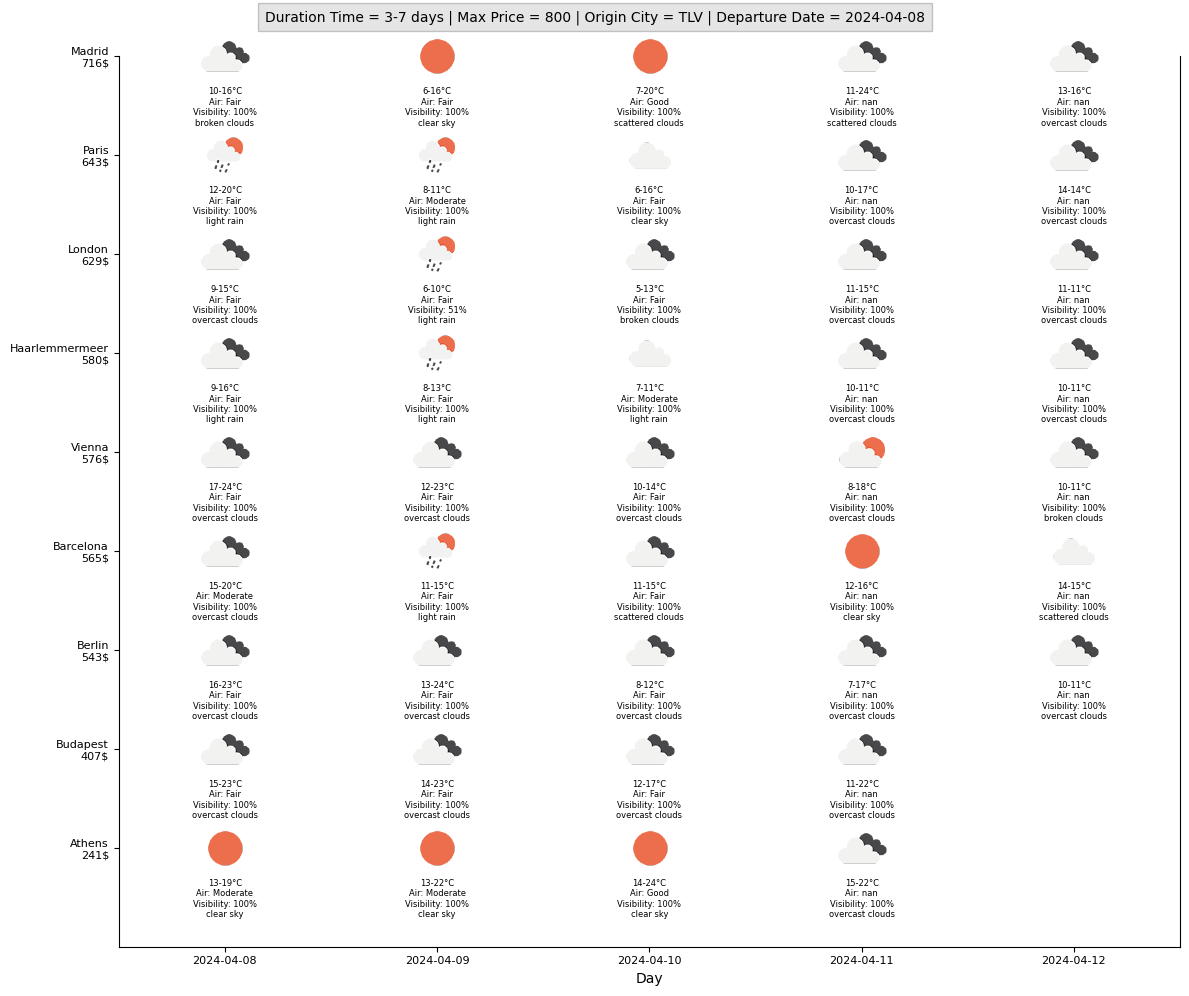

In [16]:
def main():
    __doc__=    """
    Executes the main program flow to generate a visual representation of daily weather forecasts for multiple cities.
    Note:
    - This function orchestrates the entire process of fetching weather data, aggregating it, and plotting it on a graph.
    - It retrieves user query parameters, fetches flight destinations, matches them with city names,
      retrieves weather and air pollution forecasts for each destination, and aggregates the data.
    - The function then generates a plot showing daily weather forecasts for each city, including temperature range,
      air quality index description, visibility, and weather description.
    - The plot also includes a header displaying user query parameters.
    """
    global duration,maxPrice,origin,depature_date
    try:
        logging.info('program starts')
        duration,maxPrice,origin,depature_date=get_user_query_parameters()
        print('user parameters:' ,duration,maxPrice,origin,depature_date)
        logging.info('user parameters:' ,duration,maxPrice,origin,depature_date)
        global openweathermap_api_key
        amadeus_access_token=get_token_from_amadeus()
        flight_destinations=get_possible_flight_destinations(amadeus_access_token,origin=origin,departureDate=depature_date,oneWay='false',duration=duration,nonStop='false',maxPrice=maxPrice,viewBy='DATE')
        df_airport_codes_cities=get_cities_names_with_flight_destinations(flight_destinations)
        df_airport_codes_cities['lon_lan']=df_airport_codes_cities.apply(city_lon_lat,axis=1)
        cities_dict=(df_airport_codes_cities[['city_name','lon_lan']]).to_dict(orient='tight')
        weather_forecast_for_all_destinations=pd.DataFrame()
        air_pollution_for_all_destinations=pd.DataFrame()
        
        #looping on all city destinations and extracting the weather and air-pollution forecast, into a one big data frame:
        for i in range(len(cities_dict['data'])):
            city_name=cities_dict['data'][i][0]
            lat=cities_dict['data'][i][1]['lat']
            lon=cities_dict['data'][i][1]['lon']
            weather_forecast_for_all_destinations=pd.concat([weather_forecast_for_all_destinations,weather_forecast_for_city(openweathermap_api_key,city_name,lat,lon)])
            air_pollution_for_all_destinations=pd.concat([air_pollution_for_all_destinations,get_air_pollution_city(openweathermap_api_key,city_name,lat,lon)])   
            logging.debug('city name: {city_name}lat: {lat}lon: {lon}')
        weather_air_pol_for_all_destinations=pd.merge(left=weather_forecast_for_all_destinations,\
                                                    right=air_pollution_for_all_destinations,\
                                                    how='left',\
                                                    left_on=['dt','city_name'],\
                                                    right_on=['dt','city_name'])    
        weather_air_pol_for_all_destinations['relevant_for_flight'] = weather_air_pol_for_all_destinations.apply(is_date_relvant,args=[flight_destinations,df_airport_codes_cities], axis=1)
        
        weather_air_pol_for_all_destinations.query('relevant_for_flight==1',inplace=True)
        relvant_columns=['city_name','pop','dt','aqi desc',\
                         'visibility','rain.3h','main.feels_like','main.temp_min','main.temp_max','clouds.all','wind.speed',\
                            'wind.deg','sys.pod','weather.main','weather.description','weather.icon']
        try:
            with open('weather_air_pol_for_all_destinations.csv','w') as f:              
                weather_air_pol_for_all_destinations[relvant_columns].to_csv(f,sep=',',lineterminator='\n',index=False)
        except PermissionError:
            logging.exception('File weather_air_pol_for_all_destinations.csv is open')
            raise Exception('File weather_air_pol_for_all_destinations.csv is open. please close it')
        except Exception as e:
            logging.exception(e)
            raise Exception(e)
        weather_air_pol_for_all_destinations=weather_air_pol_for_all_destinations[relvant_columns]
        #weather_air_pol_for_all_destinations.info()
        global daily_fcst
        daily_fcst=reduce_hourly_forecast_to_daily(weather_air_pol_for_all_destinations) 
        daily_fcst['main_weather_img']=daily_fcst['main_weather_icon'].apply(lambda col:f'https://openweathermap.org/img/wn/{col}@2x.png')
        daily_fcst=pd.merge(left=daily_fcst,right=flight_destinations_with_city_names[['city_name','Country name','price.total']],left_on='city_name',right_on='city_name')
        with open('daily_fcst.csv','w') as f:              
            daily_fcst.to_csv(f,sep=',',lineterminator='\n',index=False)
        visual_weather_destinations_plot(daily_fcst,duration,maxPrice,origin,depature_date)
    except Exception as e:
        print ('An error occured: ',e)
        raise Exception(e)
        
if __name__ == "__main__":
    main()
    logging.info('program over')
    logging.shutdown()